# Working with Raster data

Geographic data comes in two common representations. 

The first, called *vector data*, refers to a representation where coordinates are indexed in continuous space with a position vector. Coordinates have no dimension, but are combined togehter to form *geometries*, such as points, lines, and polygons. These combinations have [certain rules](http://www.opengeospatial.org/standards/sfa) for how they can be combined into geometries.

In the previous notebook, we worked mainly with vector geometries, although the basemaps we used to construct better maps were *raster* representations of geographical data. *Raster* representations of geographic data are like images; they are composed of small identical polygons (usually squares) with a single value. Usually, Raster datasets map naturally to an *array*, where each element is the observed value at a given cell. If there are multiple sensed values at each site, then each value is assigned a *band*. In geography, this terminology comes from early work in *digital aerial photography* applications, where each *band* represented an electromagnetic wavelength (such as infrared, red, green, blue, ultraviolet, etc.) recorded by an aerial sensor. This is opposed to *vector data*, which grew out of applications in computer graphics. 

Below, we discuss a few methods for working with rasters, as well as ways to combine rasters. 

## Reading & Writing raster data using Rasterio

There is a wide variety of raster data processing methods in Python, given the extensive ecosystem of satellite imagery and analysis tools for Python. For large raster datasets, the [pangeo](http://pangeo.io/packages.html) project may be of interest. However, many common processing pipelines rely on [`rasterio`](https://rasterio.readthedocs.io/en/stable/), which is built on the [GEOS library](https://rasterio.readthedocs.io/en/stable/installation.html), like [PostGIS](https://postgis.net/docs/postgis_installation.html#install_requirements) and [shapely](https://shapely.readthedocs.io/en/stable/project.html#requirements), which underlies `geopandas`.

In [1]:
import rasterio # the GEOS-based raster package
import numpy # the array computation library
import geopandas # the GEOS-based vector package
import contextily # the package for fetching basemaps
import matplotlib.pyplot as plt # the visualization package
%matplotlib inline

To [get started with `rasterio`](https://rasterio.readthedocs.io/en/stable/quickstart.html), you should use `rasterio.open()` to create a "dataset" (or, sometimes called a "file handle"). Below, we'll open a dataset containing the nighttime lights sensed from Texas:

In [2]:
nightlight_file = rasterio.open('../data/txlights.tif')

 The `rasterio.open()` command works similarly to the built-in Python `open` command, but offers different methods that are relevant to raster data. For instance, the `read()` method takes an argument for the `band` which you want to read from the data (indexed from 1):

In [3]:
nightlights = nightlight_file.read(1)

as well as quite a few other attributes, such as:

In [4]:
nightlight_file.crs # the coordinate reference system

CRS({'init': 'epsg:4326'})

In [5]:
nightlight_file.shape # the shape of the raster image

(1277, 1577)

When a band is `read()`, the values from the band are stored in memory as a `numpy.ndarray`. This means that the band read in from `txnightlights.tiff` can be operated on like a typical `numpy` array. To show the data, we can use the same approach as when we were using `contextily` tiles: 

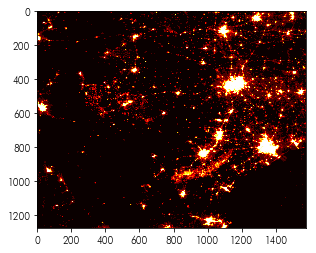

In [6]:
plt.imshow(nightlights, cmap='hot')

For multi-band images, the `rasterio.plot.show()` method can also provide [detailed, multi-band plots](https://rasterio.readthedocs.io/en/stable/topics/plotting.html):

In [7]:
from rasterio import plot as rioplot

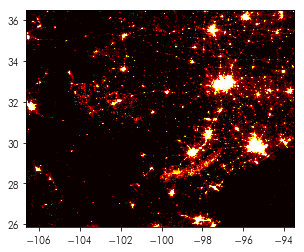

In [8]:
rioplot.show(nightlight_file, cmap='hot')

Looking carefully, you'll note that the `rasterio.plot.show()` function also sets the axis correctly to latitude (for the `yaxis`) and longitude (for the `xaxis`). To do this correctly for the raster dataset, we would need to construct its *extent*. This is already provided in one form by `nightlight_file`:

In [9]:
nightlight_file.bounds

BoundingBox(left=-106.6495132446289, bottom=25.852210786788664, right=-93.5078466305289, top=36.493877410888665)

But, `matplotlib` and geographic packages like `rasterio` and `geopandas` use different ordering conventions for their bounding box information. 

> geographic information systems (bounds): (west, south, north, east)
> matplotlib (extent): (west, east, south, north)

We will consistently use the term *bounds* or *bound form* to refer to the top ordering, and *extent* or *extent form* when referring to the bottom ordering. As such, we must re-arrange the `nightlight_file.bounds` to `extent` form, expected by `matplotlib`:

In [10]:
nightlight_extent = numpy.asarray(nightlight_file.bounds)[[0,2,1,3]]

Then, we can use it in `imshow` to correct the axis labels:

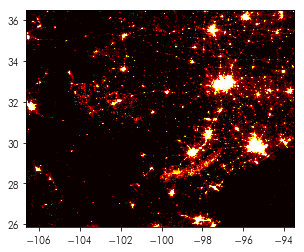

In [11]:
plt.imshow(nightlights, cmap='hot', extent=nightlight_extent)

## Subsetting Rasters

Often, rasters and vectors have to be used together. It's often the case that many kinds of geographical processes are being analyzed in a single area of study, so more than one kind of representation is needed for a given analytical purpose. Below, we'll show a few ways to use vector features (such as polygons or points) together with a raster, such as the nightlight data shown above. 

For instance, our data shows the nightlights for *all* of Texas. However, our other data sources used in the previous notebooks in this workshop focus explicitly on the city of Austin. To focus the raster down to Austin, we can use the `neighborhoods` data, which we converted into geographic information earlier. 

In [12]:
neighborhoods = geopandas.read_file('../data/neighborhoods.gpkg')

The `neighborhoods` data, like any data stored in a `geopandas.GeoDataFrame`, has its `total_bounds` recomputed on the fly. Thus, the bounding box for our neighborhoods in Austin (which is a good proxy for the bounding box of Austin itself) is the `total_bounds` of our `neighborhood` dataframe:

In [13]:
austin_bbox = neighborhoods.total_bounds

Subsetting raster data in `rasterio` is easiest to do *before* it is read into memory (although it is possible to do so after `read()`). Subsetting data requires a `rasterio.windows.Window` object to be built that describes the area to focus on. There are many helper functions to build windows, but the simplest is:

In [14]:
nightlight_file.window?

Signature: nightlight_file.window(left, bottom, right, top, precision=None)
Docstring:
Get the window corresponding to the bounding coordinates.

The resulting window is not cropped to the row and column
limits of the dataset.

Parameters
----------
left: float
    Left (west) bounding coordinate
bottom: float
    Bottom (south) bounding coordinate
right: float
    Right (east) bounding coordinate
top: float
    Top (north) bounding coordinate
precision: int, optional
    Number of decimal points of precision when computing inverse
    transform.

Returns
-------
window: Window
File:      ~/anaconda3/envs/ana/lib/python3.7/site-packages/rasterio/windows.py
Type:      method


This takes the coordinates from a bounding box and provides a `rasterio.windows.Window` object. We can use it directly from our `austin_bbox` data using `*`, the unpack operator in Python:

In [15]:
austin_window = nightlight_file.window(*austin_bbox)

Now, when we `read()` in our data, we can use this `rasterio.windows.Window` object to only read the data we want to analyze: that within the bounds of the `neighborhoods` in Austin:

In [16]:
austin_nightlights = nightlight_file.read(1, window=austin_window)

To see what this looks like together, we can make a plot that contains both raster and vector data in the same fashion we have done with basemaps in `contextily`:

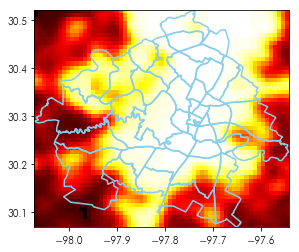

In [17]:
plt.imshow(austin_nightlights, extent=austin_bbox[[0,2,1,3]], cmap='hot')
neighborhoods.boundary.plot(ax=plt.gca(), color='skyblue')

Writing out raster geodata is somewhat more complex. Since the actual raster contains much *less* information about the geographic structure of the raster than, say, a `geopandas.GeoDataFrame`, it is necessary to supply quite a bit more information to the `rasterio.open()` and `rasterio.write()` functions. In most cases, it is necessary to supply:

1. the size of the image in pixels (since the image may differ from the size of the array being used to *write* to the image)
2. the coordinate reference system for the image (since the `numpy.ndarray` has no information about coordinate reference systems inside of it)
3. the "transformation", which is the `rasterio.Affine` class that describes the [affine transform matrix](https://en.wikipedia.org/wiki/Affine_transformation#Image-transformation) of the array that is required to "fit" into the coordinate reference system provided. 

Again, fotunately, there are helper functions in `rasterio` to construct these things. For instance, as we saw above, the coordinate reference system for an image is stored in:

In [18]:
nightlight_file.crs

CRS({'init': 'epsg:4326'})

And, in many cases, the transform can be constructed directly from a `rasterio.window.Window` object (assuming that this is truly the transform of the raster). 

In [19]:
austin_transform = nightlight_file.window_transform(austin_window)

Thus, to write our new raster out that focues exlusively on Austin, we can use the following `open()` & `write()` calls:

In [20]:
with rasterio.open('../data/austinlights.tif', #filename
                   'w', # file mode, with 'w' standing for "write"
                   driver='GTiff', # format to write the data
                   height=austin_nightlights.shape[0], # height of the image, often the height of the array
                   width=austin_nightlights.shape[1], # width of the image, often the width of the array
                   count=1, # the number of bands to write
                   dtype=rasterio.ubyte, # the dtype of the data, usually `ubyte` if data is stored in integers
                   crs=nightlight_file.crs, # the coordinate reference system of the data
                   transform=austin_transform # the affine transformation for the image
                  ) as outfile:
    outfile.write(austin_nightlights, indexes=1) # write the `austin_nightlights` as the first band

## Working between representations

Often, it's necessary to move data between representations. A few common operations are required to work fluently between representations:

- **polygonizing rasters**: drawing vector polygons around cell patches that have a given value
- **rasterizing vector features**: converting vector values into a raster, at a given, prespecified resolution. 
- **zonal statistics**: computing statistics about raster cells that intersect vector features. When done with point-based vector features, this is often called *sampling* or *resampling* from the raster. 

converting between vector and raster representations is often [fairly straightforward](https://rasterio.readthedocs.io/en/stable/topics/features.html#extracting-shapes-of-raster-features), since these involve very well-specified transformations of the input data. Zonal statistics, however, are very often required in analytical applications, and can occasionally be complex or confusing to construct. As such, we'll cover techniques for computing zonal statistics about polygon and point features in an efficient fashion. 

## Zonal Statistics

For simple, direct applications, there is a dedicated package in python (called [`python-rasterstats`](https://pythonhosted.org/rasterstats/)) for doing zonal statistics on raster data:

In [21]:
import rasterstats

For computing raster statistics from numpy arrays in memory, it is necessary to specify the affine transform (using the `affine` argument) that relates the array to the geometry:

In [22]:
rasterstats.zonal_stats(neighborhoods.geometry.head(), austin_nightlights, 
                        affine=austin_transform)

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'min': 15.0, 'max': 60.0, 'mean': 45.2, 'count': 45},
 {'min': 44.0, 'max': 62.0, 'mean': 59.125, 'count': 48},
 {'min': 39.0, 'max': 60.0, 'mean': 51.73684210526316, 'count': 57},
 {'min': 6.0, 'max': 60.0, 'mean': 25.09259259259259, 'count': 162},
 {'min': 63.0, 'max': 63.0, 'mean': 63.0, 'count': 6}]

To compute your own user-defined functions, you can pass them along as well inside of the `add_stats` argument. Further, the `stats` keyword argument can also specify which statistics you are interested in computing, stated in a string. Supported options are detailed [here](https://pythonhosted.org/rasterstats/manual.html#statistics), but include (at the time of writing):

- *min*
- *max*
- *mean*
- *count*
- sum
- std
- median
- majority (aka most common value, in the case where no majority exists)
- minority (aka least common value)
- unique
- range
- nodata
- percentile

Ones stated in italics are computed by default, as you see in the first computation. So, for instance, to do a special computation on the input, we might use something like:

In [23]:
from scipy.stats import skew

def flatskew(x):
    """
    Compute the skewness of all values in an input masked array
    """
    return skew(x.data, axis=None)

In [24]:
rasterstats.zonal_stats(neighborhoods.geometry.head(), austin_nightlights, 
                        affine=austin_transform, stats=' ',
                        add_stats=dict(skew=flatskew))

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'skew': -0.6249165889746923},
 {'skew': -1.8648413772281802},
 {'skew': -1.3232169843095356},
 {'skew': 0.6716749821144349},
 {'skew': 0.0}]

Notably, as we'll discuss in detail below when we get into how zonal stats work, the functions passed through `add_stats` must accept masked arrays as input. 

The `rasterstats` package is flexible, but it is often better to work directly with `rasterio`. The interpolation strategies used in `rasterstats` for converting raster features to vector values can yield unexpected results. Using `rasterio` directly, you can ensure that your results are exactly what you intend. 

Therefore, we'll walk through a little bit of how you might implement zonal statistics by yourself using `rasterio.mask`. 

A `mask` is like a filter on the values of an array. Using a `mask`, you can select only pixels that intersect a given shape. So, for example, consider the first neighborhood in our `neighborhoods` data (shown in green):

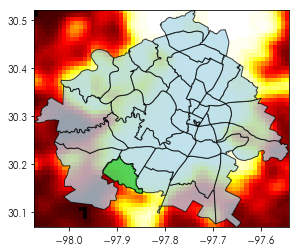

In [25]:
ax = neighborhoods.geometry.plot(color='lightblue', alpha=.75, edgecolor='k')
neighborhoods.geometry[[0]].plot(color='limegreen', ax=ax, alpha=.75, edgecolor='k')
ax.imshow(austin_nightlights, extent=austin_bbox[[0,2,1,3]], cmap='hot')

Using the mask module, we can focus the raster onto cells that are *around* that feature. So, for instance, in the zoomed-in plot of that neighborhood below:

array([-97.928875, -97.846623,  30.139555,  30.218407])

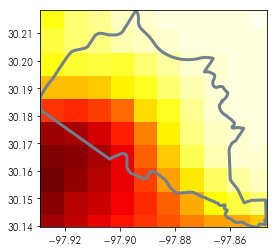

In [26]:
test_shape = neighborhoods.geometry[[0]]
plt.imshow(austin_nightlights, extent=neighborhoods.total_bounds[[0,2,1,3]], cmap='hot')
test_shape.boundary.plot(ax = plt.gca(), color='slategrey', linewidth=3)
plt.axis(test_shape.total_bounds[[0,2,1,3]])

The `rasterio.mask` function helps us to select only the cells that intersect the geometry itself.

In [27]:
from rasterio.mask import mask

`rasterio` masks operate on the filehandle, rather than on an array. This improves efficiency, because the whole raster does not have to be read into memory. In the simplest case, using the `mask` function on a single geomery works as follows:

In [28]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True)

The `crop()` argument ensures that the outputted raster only covers the extent of the input features. When `crop()` is false (which occurs by default), the whole raster shape is retained. We use it here to avoid reading in the whole raster, and to make it easier to visualize the cropped component. 

The `mask` function returns an array with the shape `(n_bands, n_rows, n_columns)`. Thus, when working with a single band, the `mask` function will output an array that has an "extra" dimension; the array will be three-dimensional despite the output only having two effective dimensions. So, we must use `squeeze()` to remove extra dimensions that only have one element:

In [29]:
print('initial shape: {}'.format(masked.shape)) # we only need the (10,11) array
masked = masked.squeeze()
print('final shape: {}'.format(masked.shape))

initial shape: (1, 10, 11)
final shape: (10, 11)


Then, to visualize how this masking works, we can plot the masked array and the polygon used to build the mask together:

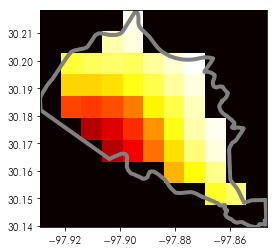

In [30]:
plt.imshow(masked.squeeze(), cmap='hot', extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

Note that this is *underfilled*, in that some pixels intersect the boundary of our test shape, but are not retained by the mask. Therefore, we can ensure that all intersecting pixels are retained using the `all_touches` argument, which will *overfill* the boundary and pick all cells that intersect the vector feature:

In [31]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True, all_touched=True)

We can visualize this again in the same fashion:

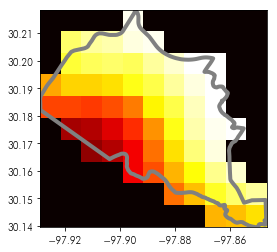

In [32]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

The resulting mask is a standard numpy array. To see how these look:

In [33]:
masked

array([[[ 0,  0,  0,  0, 59,  0,  0,  0,  0,  0,  0],
        [ 0, 51, 54, 55, 58, 59,  0,  0,  0,  0,  0],
        [ 0, 48, 50, 51, 50, 54, 57, 60, 60,  0,  0],
        [37, 41, 41, 42, 46, 49, 54, 58, 60,  0,  0],
        [28, 28, 27, 29, 33, 44, 49, 56, 60,  0,  0],
        [ 0, 14, 15, 19, 26, 35, 46, 55, 59, 60,  0],
        [ 0,  0, 12, 15, 21, 32, 42, 52, 58,  0,  0],
        [ 0,  0,  0,  0, 21, 29, 38, 45, 53, 57,  0],
        [ 0,  0,  0,  0,  0,  0, 32, 39, 47, 51, 54],
        [ 0,  0,  0,  0,  0,  0,  0,  0, 38, 39, 42]]], dtype=uint8)

By default, areas outside of the shape are filled with zeros. This is unfortunate for raster statistics, since a no-data value of zero will usually skew the zonal statistics. Including the zeros, the mean of this area is:

In [34]:
masked.mean()

24.490909090909092

However, for only the cells that are included in the selection, the mean is quite different:

In [35]:
masked[masked.nonzero()].mean()

43.45161290322581

To ensure that the mask does not bias towards the fill value, we can use the `filled` argument. When `False`, the array will be *masked*, rather than filled with a default value. This mask makes the return a numpy `MaskedArray`, which behaves slightly differently from a standard numpy array. 

In [36]:
masked, mask_transform = mask(dataset=nightlight_file, 
                              shapes=test_shape, crop=True, 
                              all_touched=True, 
                              filled=False)

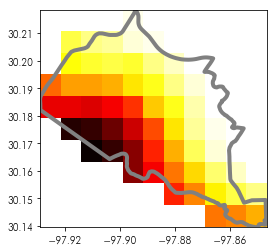

In [37]:
plt.imshow(masked.squeeze(), cmap='hot', 
           extent=test_shape.total_bounds[[0,2,1,3]])
test_shape.boundary.plot(ax=plt.gca(), color='grey', linewidth=4)

Seeing the values again, we can see that the masked array itself represents the values in a substantially different manner than the default array filled with zeros outside of the polygon:

In [38]:
masked

masked_array(
  data=[[[--, --, --, --, 59, --, --, --, --, --, --],
         [--, 51, 54, 55, 58, 59, --, --, --, --, --],
         [--, 48, 50, 51, 50, 54, 57, 60, 60, --, --],
         [37, 41, 41, 42, 46, 49, 54, 58, 60, --, --],
         [28, 28, 27, 29, 33, 44, 49, 56, 60, --, --],
         [--, 14, 15, 19, 26, 35, 46, 55, 59, 60, --],
         [--, --, 12, 15, 21, 32, 42, 52, 58, --, --],
         [--, --, --, --, 21, 29, 38, 45, 53, 57, --],
         [--, --, --, --, --, --, 32, 39, 47, 51, 54],
         [--, --, --, --, --, --, --, --, 38, 39, 42]]],
  mask=[[[ True,  True,  True,  True, False,  True,  True,  True,  True,
           True,  True],
         [ True, False, False, False, False, False,  True,  True,  True,
           True,  True],
         [ True, False, False, False, False, False, False, False, False,
           True,  True],
         [False, False, False, False, False, False, False, False, False,
           True,  True],
         [False, False, False, False, Fals

By default, methods like `mean()`, `min()`, or `max()` of masked arrays will return the correct result:

In [39]:
masked.mean()

43.45161290322581

But, more complicated statistics may need to be used directly from the `numpy.ma` module, rather than those used in `numpy` alone:

In [40]:
numpy.ma.median(masked)

46.5

In [41]:
numpy.median(masked)

/home/lw17329/anaconda3/envs/ana/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


masked

Since this works for each geometry, it is possible to *apply* this mask function over the geometries of a `GeoDataFrame` and include it in a typical pandas `apply` chain:

In [42]:
def clean_mask(geom, dataset=nightlight_file, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('all_touched', True)
    mask_kw.setdefault('filled', False)
    masked, mask_transform = mask(dataset=dataset, shapes=(geom,),
                                  **mask_kw)
    return masked

In [43]:
neighborhoods['nightlights'] = neighborhoods.geometry.apply(clean_mask).apply(numpy.ma.median)

Now, this `nightlights` column contains the median nighttime light sensed within each neighborhood of Austin:

In [44]:
neighborhoods.nightlights.head()

0    46.5
1    60.0
2    53.0
3    22.0
4    63.0
Name: nightlights, dtype: float64

To map this, we'll first grab a basemap:

In [45]:
basemap, basemap_extent = contextily.bounds2img(*neighborhoods.to_crs(epsg=3857).total_bounds, 
                                                zoom=10)

And then construct a typical map on top:

array([-10917264.20931646, -10858277.45829849,   3512350.07574952,
         3570742.87985925])

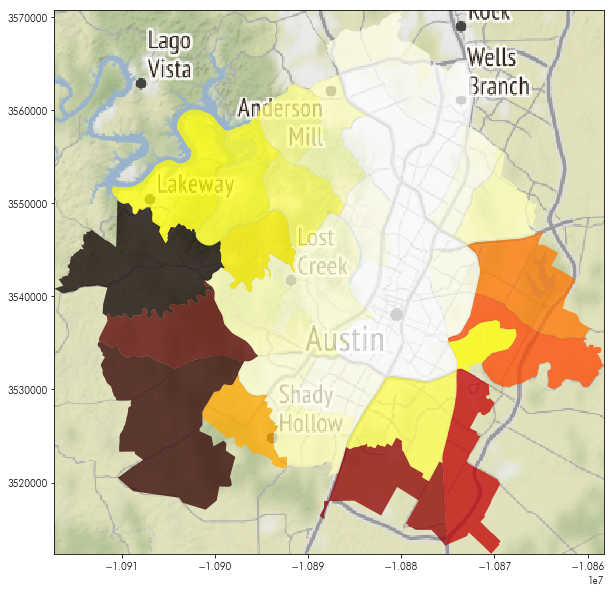

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(basemap, extent=basemap_extent)
neighborhoods.to_crs(epsg=3857).plot('nightlights', 
                                     cmap='hot', ax = plt.gca(), alpha=.75)
plt.axis(neighborhoods.to_crs(epsg=3857).total_bounds[[0,2,1,3]])

which broadly comports with our perception of what the neighborhood brightness ought look like:

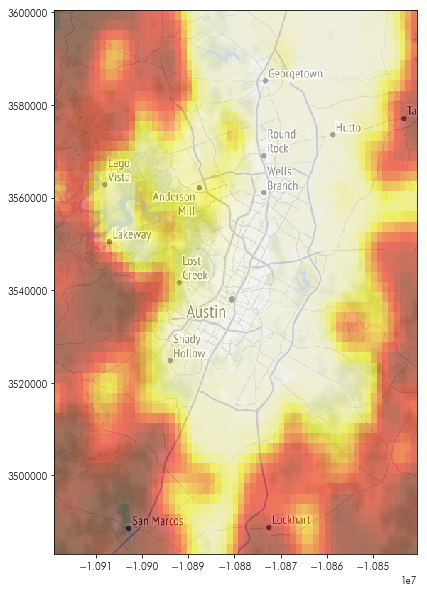

In [47]:
plt.figure(figsize=(10,10))
plt.imshow(basemap, extent=basemap_extent)
plt.imshow(austin_nightlights, extent=basemap_extent, cmap='hot', alpha=.5)

## Getting values at cells?

To get the values of a raster at specific vector points, there are a few ways this can be done. Conceptually, one could use *very* small buffers and apply the same zonal statistics method used above. But, this is very computationally wasteful, and it is often unclear as to how small a buffer has to be to avoid hitting a boundary between cells in the raster. Therefore, there are often dedicated functions to compute the raster value at vector coordinates.

To show this, let's first read in the `listings` data we used in the previous notebook:

In [129]:
listings = geopandas.read_file('../data/listings.gpkg')

While the `rasterstats.point_query` function is available, using the `.sample()` method from `rasterio` is recommended. 

To work with the `rasterio.sample` method, we unfortunately cannot use `GeoDataFrame.geometry` directly. Instead, one *can* use the `GeoDataFrame.geometry.x` and `GeoDataFrame.geometry.y` methods to access the `x` and `y` coordinates separately:

In [144]:
coordinates = numpy.vstack((listings.geometry.x.values, listings.geometry.y.values)).T
brightnesses = nightlight_file.sample(coordinates)

In [145]:
listings['brightness_rasterio'] = numpy.vstack(brightnesses)

Then, we can map these values just like before:

array([-10915271.25647279, -10860398.53987606,   3516163.35327712,
         3569570.08939497])

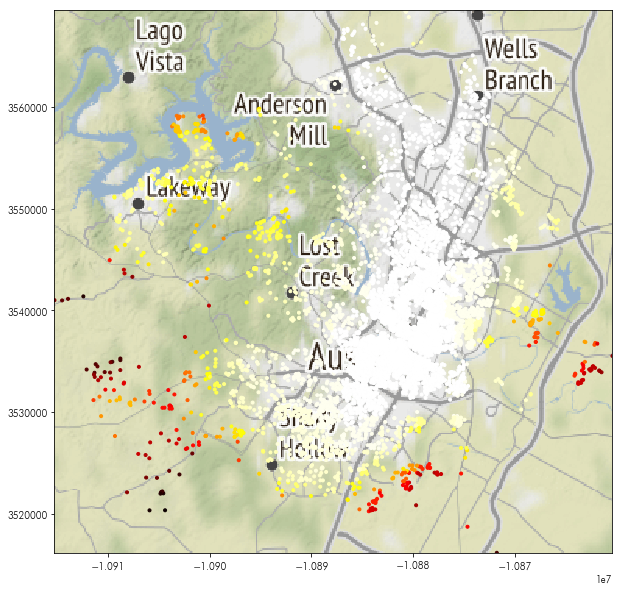

In [146]:
plt.figure(figsize=(10,10))
plt.imshow(basemap, extent=basemap_extent)
listings.to_crs(epsg=3857).plot('brightness_rasterio', ax=plt.gca(), 
                                marker='.', cmap='hot')
plt.axis(listings.to_crs(epsg=3857).total_bounds[[0,2,1,3]])

From here, you should now be equipped to tackle the `rasters-problemset.ipynb`!